In [9]:
from __future__ import division, print_function
import nibabel as nib
import numpy as np
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel

fetch_stanford_hardi()
img, gtab = read_stanford_hardi()
data = img.get_data()
affine = img.affine

print('Computing brain mask...')
b0_mask, mask = median_otsu(data, vol_idx=[0])

print('Computing tensors...')
tenmodel = TensorModel(gtab)
tensorfit = tenmodel.fit(data, mask=mask)

"""
Next, we set our red-green-blue thresholds to (0.6, 1) in the x axis and
(0, 0.1) in the y and z axes respectively. These values work well in practice
to isolate the very RED voxels of the cfa map.

Then, as assurance, we want just RED voxels in the CC (there could be noisy
red voxels around the brain mask and we don't want those). Unless the brain
acquisition was badly aligned, the CC is always close to the mid-sagittal
slice.

The following lines perform these two operations and then saves the
computed mask.

"""

print('Computing worst-case/best-case SNR using the corpus callosum...')
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box

threshold = (0.6, 1, 0, 0.1, 0, 0.1)
CC_box = np.zeros_like(data[..., 0])

mins, maxs = bounding_box(mask)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

/tmp/ipykernel_31866/2088246366.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


Computing brain mask...
Computing tensors...
Computing worst-case/best-case SNR using the corpus callosum...


In [13]:
fetch_stanford_hardi()

({'HARDI150.nii.gz': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.nii.gz',
   '0b18513b46132b4d1051ed3364f2acbc'),
  'HARDI150.bval': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.bvals',
   '4e08ee9e2b1d2ec3fddb68c70ae23c36'),
  'HARDI150.bvec': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.bvecs',
   '4c63a586f29afc6a48a5809524a76cb4')},
 '/u/home/h/haleywan/.dipy/stanford_hardi')

In [10]:
CC_box[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
                                     return_cfa=True)

cfa_img = nib.Nifti1Image((cfa*255).astype(np.uint8), affine)
mask_cc_part_img = nib.Nifti1Image(mask_cc_part.astype(np.uint8), affine)
nib.save(mask_cc_part_img, 'mask_CC_part.nii.gz')

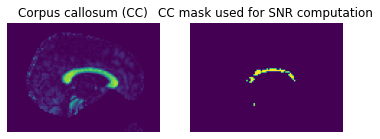

In [11]:
import matplotlib.pyplot as plt
region = 40
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 2, 1)
plt.title("Corpus callosum (CC)")
plt.axis('off')
red = cfa[..., 0]
plt.imshow(np.rot90(red[region, ...]))

plt.subplot(1, 2, 2)
plt.title("CC mask used for SNR computation")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part[region, ...]))
fig.savefig("CC_segmentation.png", bbox_inches='tight')

In [12]:


"""
.. figure:: CC_segmentation.png
   :align: center

"""

"""Now that we are happy with our crude CC mask that selected voxels in the
x-direction, we can use all the voxels to estimate the mean signal in this
region.

"""

mean_signal = np.mean(data[mask_cc_part], axis=0)

"""Now, we need a good background estimation. We will re-use the brain mask
computed before and invert it to catch the outside of the brain. This could
also be determined manually with a ROI in the background.
[Warning: Certain MR manufacturers mask out the outside of the brain with 0's.
One thus has to be careful how the noise ROI is defined].
"""

from scipy.ndimage.morphology import binary_dilation
mask_noise = binary_dilation(mask, iterations=10)
mask_noise[..., :mask_noise.shape[-1]//2] = 1
mask_noise = ~mask_noise
mask_noise_img = nib.Nifti1Image(mask_noise.astype(np.uint8), affine)
nib.save(mask_noise_img, 'mask_noise.nii.gz')

noise_std = np.std(data[mask_noise, :])
print('Noise standard deviation sigma= ', noise_std)

"""We can now compute the SNR for each DWI. For example, report SNR
for DW images with gradient direction that lies the closest to
the X, Y and Z axes.
"""

# Exclude null bvecs from the search
idx = np.sum(gtab.bvecs, axis=-1) == 0
gtab.bvecs[idx] = np.inf
axis_X = np.argmin(np.sum((gtab.bvecs-np.array([1, 0, 0]))**2, axis=-1))
axis_Y = np.argmin(np.sum((gtab.bvecs-np.array([0, 1, 0]))**2, axis=-1))
axis_Z = np.argmin(np.sum((gtab.bvecs-np.array([0, 0, 1]))**2, axis=-1))

for direction in [0, axis_X, axis_Y, axis_Z]:
    SNR = mean_signal[direction]/noise_std
    if direction == 0:
        print("SNR for the b=0 image is :", SNR)
    else:
        print("SNR for direction", direction, " ",
              gtab.bvecs[direction], "is :", SNR)

"""SNR for the b=0 image is : ''42.0695455758''"""
"""SNR for direction 58  [ 0.98875  0.1177  -0.09229] is : ''5.46995373635''"""
"""SNR for direction 57  [-0.05039  0.99871  0.0054406] is : ''23.9329492871''"""
"""SNR for direction 126 [-0.11825  -0.039925  0.99218 ] is : ''23.9965694823''"""

"""

Since the CC is aligned with the X axis, the lowest SNR is for that gradient
direction. In comparison, the DW images in the perpendical Y and Z axes have a
high SNR. The b0 still exhibits the highest SNR, since there is no signal
attenuation.

Hence, we can say the Stanford diffusion data has a 'worst-case' SNR of
approximately 5, a 'best-case' SNR of approximately 24, and a SNR of 42 on the
b0 image.

"""

"""
References
----------

.. [Descoteaux2011] Descoteaux, M., Deriche, R., Le Bihan, D., Mangin, J.-F.,
   and Poupon, C. Multiple q-shell diffusion propagator imaging. Medical Image
   Analysis, 15(4), 603, 2011.

.. [Jones2013] Jones, D. K., Knosche, T. R., & Turner, R. White Matter
   Integrity, Fiber Count, and Other Fallacies: The Dos and Don'ts of Diffusion
   MRI. NeuroImage, 73, 239, 2013.

"""


Noise standard deviation sigma=  8.17113266785504
SNR for the b=0 image is : 47.366354266706736
SNR for direction 58   [ 0.98875  0.1177  -0.09229] is : 5.918432129721111
SNR for direction 57   [-0.05039    0.99871    0.0054406] is : 26.72068171809924
SNR for direction 126   [-0.11825  -0.039925  0.99218 ] is : 27.592653853373644


"\nReferences\n----------\n\n.. [Descoteaux2011] Descoteaux, M., Deriche, R., Le Bihan, D., Mangin, J.-F.,\n   and Poupon, C. Multiple q-shell diffusion propagator imaging. Medical Image\n   Analysis, 15(4), 603, 2011.\n\n.. [Jones2013] Jones, D. K., Knosche, T. R., & Turner, R. White Matter\n   Integrity, Fiber Count, and Other Fallacies: The Dos and Don'ts of Diffusion\n   MRI. NeuroImage, 73, 239, 2013.\n\n"